## 训练U-Net模型

In [1]:
import json
import os

import pandas as pd
import torch
import torch.optim as optim
from torch.utils.data import DataLoader

from dataset import BrainSegmentationDataset as Dataset
from logger import Logger
from loss import DiceLoss, IOULoss, FocalTverskyLoss
from transform import transforms
from unet import UNet
from utils import log_images, dsc

import numpy as np
import matplotlib.pyplot as plt
from unet_2plus import UNet_2Plus
from unet_3plus import UNet_3Plus

/home/shaw/anaconda3/envs/hw4/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/shaw/anaconda3/envs/hw4/lib/python3.7/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/shaw/anaconda3/envs/hw4/lib/python3.7/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE
  warn(f"Failed to load image Python extension: {e}")


In [2]:
# 读取数据
def data_loaders(args):
    dataset_train, dataset_valid = datasets(args)

    def worker_init(worker_id):
        np.random.seed(42 + worker_id)

    loader_train = DataLoader(
        dataset_train,
        batch_size=args.batch_size,
        shuffle=True,
        drop_last=True,
        num_workers=args.workers,
        worker_init_fn=worker_init,
    )
    loader_valid = DataLoader(
        dataset_valid,
        batch_size=args.batch_size,
        drop_last=False,
        num_workers=args.workers,
        worker_init_fn=worker_init,
    )

    return loader_train, loader_valid

# 数据集定义
def datasets(args):
    train = Dataset(
        images_dir=args.images,
        subset="train",
        image_size=args.image_size,
        transform=transforms(scale=args.aug_scale, angle=args.aug_angle, flip_prob=0.5),
    )
    valid = Dataset(
        images_dir=args.images,
        subset="validation",
        image_size=args.image_size,
        random_sampling=False,
    )
    return train, valid

# 数据处理
def dsc_per_volume(validation_pred, validation_true, patient_slice_index):
    dsc_list = []
    num_slices = np.bincount([p[0] for p in patient_slice_index])
    index = 0
    for p in range(len(num_slices)):
        y_pred = np.array(validation_pred[index : index + num_slices[p]])
        y_true = np.array(validation_true[index : index + num_slices[p]])
        dsc_list.append(dsc(y_pred, y_true))
        index += num_slices[p]
    return dsc_list


def log_loss_summary(logger, loss, step, prefix=""):
    logger.scalar_summary(prefix + "loss", np.mean(loss), step)


def makedirs(args):
    os.makedirs(args.weights, exist_ok=True)
    os.makedirs(args.logs, exist_ok=True)


def snapshotargs(args):
    args_file = os.path.join(args.logs, "args.json")
    with open(args_file, "w") as fp:
        json.dump(vars(args), fp)

In [3]:
# 记录中间结果
exec_result = pd.DataFrame(columns=['net_function', 'active_function', 'loss_function', 'optimizer_function', 'weight_decay', 'momentum', 'use_lr_scheduler','epoch', 'val_loss', 'val_dsc'])

### 输入参数  

device: 设备编号  
batch_size: 批大小  
epochs: 训练轮数  
lr: 学习率  
vis_images: 可视化预测结果的数目 (在tensorboard中查看)  
vis_freq: 两次可视化预测结果的间隔  
weights: 训练后的模型参数路径    
images: 数据集路径   
image_size: 图像尺寸   
aug_scale: 数据增强(放缩)  
aug_angle: 数据增强(旋转)  

In [4]:
class Args:
    device = 'cuda:0'
    batch_size = 16
    epochs = 100
    lr = 0.0001
    workers = 4
    vis_images = 200
    vis_freq = 10
    weights = './weights'
    logs = './logs'
    images = './kaggle_3m'
    image_size = 256
    aug_scale = 0.05
    aug_angle = 15

In [5]:
class Args:
    device = 'cuda:0'
    batch_size = 16
    epochs = 30
    lr = 0.0001
    workers = 4
    vis_images = 200
    vis_freq = 10
    weights = './weights'
    logs = './logs'
    images = './kaggle_3m'
    image_size = 256
    aug_scale = 0.05
    aug_angle = 15

    # 定义网络模型 UNet、UNet_2plus 或 UNet_3plus
    net_function = 'UNet'
    # 定义激活函数 ReLU 或 Sigmoid
    active_function = 'ReLU'
    # 定义损失函数 DiceLoss、IOULoss 或 FocalTverskyLoss
    loss_function = 'DiceLoss'
    # 定义优化器 SGD 或 Adam
    optimizer_function = 'Adam'
    # 权重衰减系数
    weight_decay=0.0001
    # 优化器 optimizer == 'SGD'时有效
    momentum=0.9 

    # 是否使用学习率衰减
    use_lr_scheduler = False
    # 是否使用训练轮衰减StepLR,否时使用 LinearLR
    use_lr_scheduler_StepLR = False

### 数据处理和数据增强

In [6]:
args=Args()

In [7]:
makedirs(args)
snapshotargs(args)
device = torch.device("cpu" if not torch.cuda.is_available() else args.device)

loader_train, loader_valid = data_loaders(args)
loaders = {"train": loader_train, "valid": loader_valid}

reading train images...
preprocessing train volumes...
cropping train volumes...
padding train volumes...
resizing train volumes...


100it [00:51,  1.94it/s][00:51<00:00,  2.61it/s]
100%|██████████| 100/100 [00:51<00:00,  1.94it/s]


normalizing train volumes...
done creating train dataset
reading validation images...
preprocessing validation volumes...
cropping validation volumes...
padding validation volumes...
resizing validation volumes...


10it [00:07,  1.29it/s]00:07<00:06,  1.38s/it]
100%|██████████| 10/10 [00:07<00:00,  1.28it/s]


normalizing validation volumes...
done creating validation dataset


In [8]:
def main(args):
    # 网络结构。默认为 UNet
    model = None
    if args.net_function == 'UNet_2plus':     
        print('use UNet_2plus...')   
        model = UNet_2Plus(in_channels=Dataset.in_channels, n_classes=Dataset.out_channels)
    elif args.net_function == 'UNet_3plus':   
        print('use UNet_3plus...')   
        model = UNet_3Plus(in_channels=Dataset.in_channels, n_classes=Dataset.out_channels)
    else:
        model = UNet(in_channels=Dataset.in_channels, out_channels=Dataset.out_channels)
    model.to(device)

    # 损失函数。默认为 DiceLoss
    dsc_loss = None 
    if args.loss_function == 'IOULoss':
        print('use FocalLoss...')   
        dsc_loss = IOULoss() 
    elif args.loss_function == 'FocalTverskyLoss':
        print('use FocalTverskyLoss...')   
        dsc_loss = FocalTverskyLoss() 
    else:
        dsc_loss = DiceLoss()  

    # 优化器。默认为 Adam
    optimizer = optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.weight_decay)    
    if args.optimizer_function == 'SGD':
        print('use SGD...')   
        optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum, weight_decay=args.weight_decay)

    # 学习率衰减
    if args.use_lr_scheduler:
        # 训练轮衰减------每过step_size轮，将此前的学习率乘以gamma：lr = lr * gamma
        # lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5, last_epoch=-1)
        # 线性衰减------给定起始factor和最终的factor，LinearLR会在中间阶段做线性插值
        lr_scheduler = optim.lr_scheduler.LinearLR(optimizer, start_factor=1,end_factor=0.1,total_iters=args.epochs)

    best_validation_dsc = 0.0
    logger = Logger(args.logs)
    loss_train = []
    loss_valid = []

    step = 0

    for epoch in range(args.epochs):
        for phase in ["train", "valid"]:
            if phase == "train":
                model.train()
            else:
                model.eval()

            validation_pred = []
            validation_true = []

            for i, data in enumerate(loaders[phase]):
                if phase == "train":
                    step += 1

                x, y_true = data
                x, y_true = x.to(device), y_true.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == "train"):
                    y_pred = model(x)

                    loss = dsc_loss(y_pred, y_true)

                    if phase == "valid":
                        loss_valid.append(loss.item())
                        y_pred_np = y_pred.detach().cpu().numpy()
                        validation_pred.extend(
                            [y_pred_np[s] for s in range(y_pred_np.shape[0])]
                        )
                        y_true_np = y_true.detach().cpu().numpy()
                        validation_true.extend(
                            [y_true_np[s] for s in range(y_true_np.shape[0])]
                        )
                        if (epoch % args.vis_freq == 0) or (epoch == args.epochs - 1):
                            if i * args.batch_size < args.vis_images:
                                tag = "image/{}".format(i)
                                num_images = args.vis_images - i * args.batch_size
                                logger.image_list_summary(
                                    tag,
                                    log_images(x, y_true, y_pred)[:num_images],
                                    step,
                                )

                    if phase == "train":
                        loss_train.append(loss.item())
                        loss.backward()
                        optimizer.step()

                if phase == "train" and (step + 1) % 10 == 0:
                    log_loss_summary(logger, loss_train, step)
                    loss_train = []

            if phase == "valid":
                log_loss_summary(logger, loss_valid, step, prefix="val_")
                print("epoch {} | val_loss: {}".format(epoch + 1, np.mean(loss_valid)))
                mean_dsc = np.mean(
                    dsc_per_volume(
                        validation_pred,
                        validation_true,
                        loader_valid.dataset.patient_slice_index,
                    )
                )

                # 记录验证集结果
                exec_result.loc[exec_result.shape[0]] = [args.net_function, args.active_function, args.loss_function, args.optimizer_function, args.weight_decay, args.momentum, args.use_lr_scheduler,
                                                         epoch+1, np.mean(loss_valid), mean_dsc]

                logger.scalar_summary("val_dsc", mean_dsc, step)
                print("epoch {} | val_dsc: {}".format(epoch+1, mean_dsc))
                if mean_dsc > best_validation_dsc:
                    best_validation_dsc = mean_dsc
                    torch.save(model.state_dict(), os.path.join(args.weights, "{}.pt".format(args.net_function)))
                loss_valid = []

        # 学习率衰减
        if args.use_lr_scheduler:
            lr_1 = optimizer.param_groups[0]['lr']
            lr_scheduler.step()

    print("Best validation mean DSC: {:4f}".format(best_validation_dsc))

In [9]:
# # 调试
# args.epochs = 2
# args.use_lr_scheduler = True
# main(args)

In [10]:
# for optimizer_function in ['Adam','SGD']:
#     for loss_function in ['DiceLoss','IOULoss','FocalTverskyLoss']:
#         for weight_decay in [0, 0.0001, 0.0003]:
#             for use_lr_scheduler in [False, True]:

# for optimizer_function in ['Adam']:
#     for loss_function in ['DiceLoss','IOULoss']:
#         for weight_decay in [0]:
#             for use_lr_scheduler in [False]:

args.epochs = 30
# for net_function in ['UNet', 'UNet_2plus', 'UNet_3plus']:
for optimizer_function in ['Adam','SGD']:
    for loss_function in ['DiceLoss','IOULoss','FocalTverskyLoss']:
        for weight_decay in [0, 0.0001, 0.0003]:
            for use_lr_scheduler in [False, True]:
                # args.net_function = net_function
                args.optimizer_function = optimizer_function
                args.loss_function = loss_function
                args.weight_decay = weight_decay
                args.use_lr_scheduler = use_lr_scheduler

                if optimizer_function == 'SGD':
                    for momentum in [0, 0.9, 0.99]:
                        args.momentum = momentum
                        main(args)
                else:
                    main(args)

# 提示: 训练时长约1~3小时，图片预处理时间较长

epoch 1 | val_loss: 0.9323917939549401
epoch 1 | val_dsc: 0.5862443625906332
epoch 2 | val_loss: 0.9191001341456458
epoch 2 | val_dsc: 0.6432152668083015
epoch 3 | val_loss: 0.9018142563956124
epoch 3 | val_dsc: 0.7243094699954938
epoch 4 | val_loss: 0.879386427856627
epoch 4 | val_dsc: 0.6657677644267757
epoch 5 | val_loss: 0.8348367327735537
epoch 5 | val_dsc: 0.7798858781655604
epoch 6 | val_loss: 0.7839178471338182
epoch 6 | val_dsc: 0.7968029287154821
epoch 7 | val_loss: 0.7312806305431184
epoch 7 | val_dsc: 0.7887896978016358
epoch 8 | val_loss: 0.6691446673302424
epoch 8 | val_dsc: 0.8071852495369084
epoch 9 | val_loss: 0.6203153899737767
epoch 9 | val_dsc: 0.8133320735972932
epoch 10 | val_loss: 0.5712644088835943
epoch 10 | val_dsc: 0.8154965213834519
epoch 11 | val_loss: 0.5967066429910206
epoch 11 | val_dsc: 0.7201129251855276
epoch 12 | val_loss: 0.5019191276459467
epoch 12 | val_dsc: 0.9060639418432537
epoch 13 | val_loss: 0.4710450910386585
epoch 13 | val_dsc: 0.914145743

In [11]:
best_index = exec_result['val_dsc'].idxmax()
auc_best= exec_result.loc[best_index]
auc_best

net_function              UNet
active_function           ReLU
loss_function         DiceLoss
optimizer_function        Adam
weight_decay                 0
momentum                   0.9
use_lr_scheduler         False
epoch                       13
val_loss              0.471045
val_dsc               0.914146
Name: 12, dtype: object

In [12]:
exec_result.sort_values(by=['val_dsc'],ascending=[False]).head(10)

,net_function,active_function,loss_function,optimizer_function,weight_decay,momentum,use_lr_scheduler,epoch,val_loss,val_dsc
12,UNet,ReLU,DiceLoss,Adam,0,0.9,False,13,0.471045,0.914146
372,UNet,ReLU,FocalLoss,Adam,0,0.9,False,13,0.432721,0.911195
224,UNet,ReLU,IOULoss,Adam,0,0.9,True,15,0.729898,0.911171
225,UNet,ReLU,IOULoss,Adam,0,0.9,True,16,0.723834,0.911065
465,UNet,ReLU,FocalLoss,Adam,0.0001,0.9,True,16,0.544837,0.910916
230,UNet,ReLU,IOULoss,Adam,0,0.9,True,21,0.700946,0.910901
226,UNet,ReLU,IOULoss,Adam,0,0.9,True,17,0.714410,0.910775
374,UNet,ReLU,FocalLoss,Adam,0,0.9,False,15,0.402925,0.910498
228,UNet,ReLU,IOULoss,Adam,0,0.9,True,19,0.707321,0.910456
229,UNet,ReLU,IOULoss,Adam,0,0.9,True,20,0.703346,0.910364


## 改进结果

### 1.不同的损失函数对结果的影响

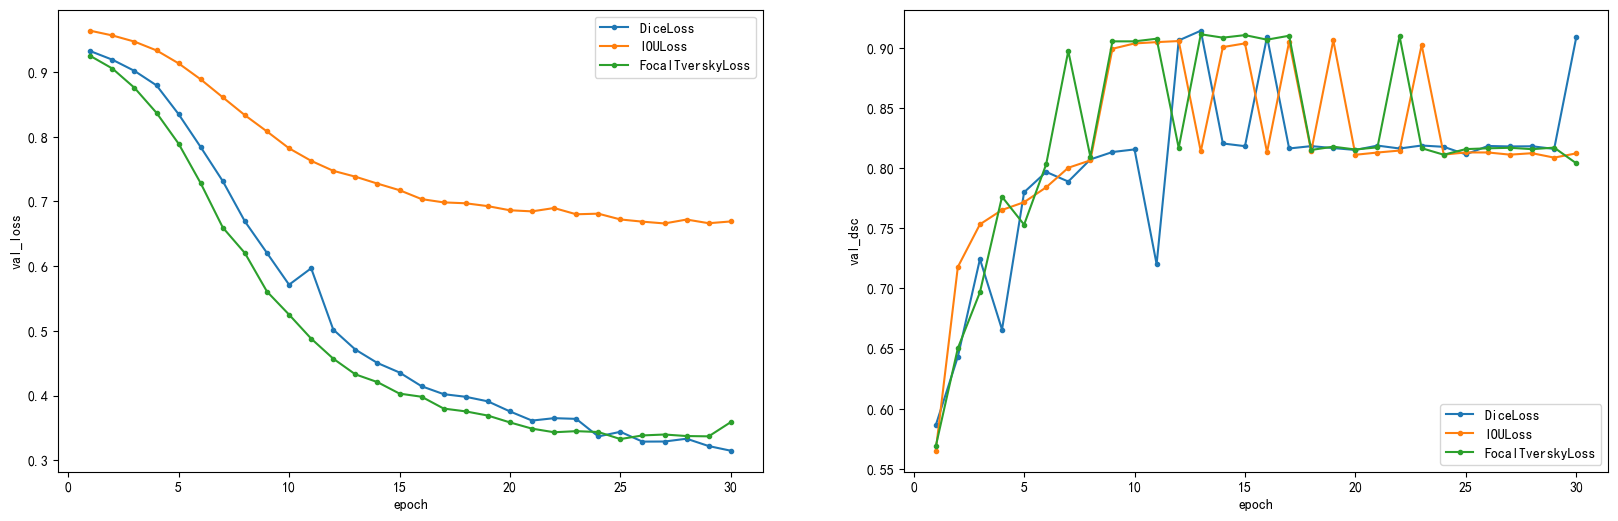

In [38]:
exec_DiceLoss = exec_result.query("loss_function == 'DiceLoss' & optimizer_function == 'Adam' & weight_decay ==0 & use_lr_scheduler ==False")
exec_IOULoss = exec_result.query("loss_function == 'IOULoss' & optimizer_function == 'Adam' & weight_decay ==0 & use_lr_scheduler ==False")
exec_FocalTverskyLoss = exec_result.query("loss_function == 'FocalLoss' & optimizer_function == 'Adam' & weight_decay ==0 & use_lr_scheduler ==False")

plt.figure(figsize=(20,6), dpi=100)
plt.rcParams['font.sans-serif']=['SimHei']
plt.subplot(121)
plt.plot(range(1,len(exec_DiceLoss)+1),exec_DiceLoss['val_loss'], marker='.', label ='DiceLoss')
plt.plot(range(1,len(exec_IOULoss)+1),exec_IOULoss['val_loss'], marker='.', label ='IOULoss')
plt.plot(range(1,len(exec_FocalTverskyLoss)+1),exec_FocalTverskyLoss['val_loss'], marker='.', label ='FocalTverskyLoss')
plt.xlabel('epoch')
plt.ylabel('val_loss')
plt.legend()
plt.subplot(122)
plt.plot(range(1,len(exec_DiceLoss)+1),exec_DiceLoss['val_dsc'], marker='.', label ='DiceLoss')
plt.plot(range(1,len(exec_IOULoss)+1),exec_IOULoss['val_dsc'], marker='.', label ='IOULoss')
plt.plot(range(1,len(exec_FocalTverskyLoss)+1),exec_FocalTverskyLoss['val_dsc'], marker='.', label ='FocalTverskyLoss')
plt.xlabel('epoch')
plt.ylabel('val_dsc')
plt.legend()
plt.show()

In [39]:
exec_DiceLoss['val_dsc'].max(), exec_IOULoss['val_dsc'].max(), exec_FocalTverskyLoss['val_dsc'].max()

(0.9141457432361209, 0.9061841483370575, 0.9111951774683913)

### 2.不同的优化器对结果的影响

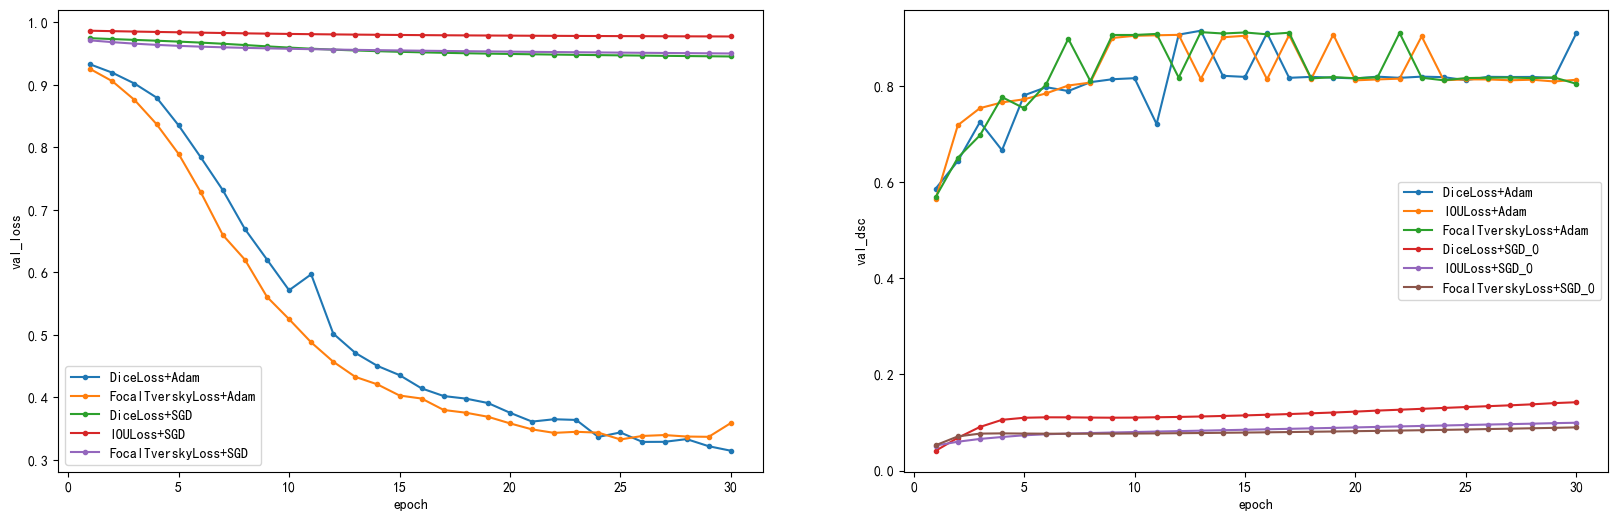

In [43]:
exec_DiceLoss_Adam = exec_result.query("loss_function == 'DiceLoss' & optimizer_function == 'Adam' & weight_decay ==0 & use_lr_scheduler ==False")
exec_IOULoss_Adam = exec_result.query("loss_function == 'IOULoss' & optimizer_function == 'Adam' & weight_decay ==0 & use_lr_scheduler ==False")
exec_FocalTverskyLoss_Adam = exec_result.query("loss_function == 'FocalLoss' & optimizer_function == 'Adam' & weight_decay ==0 & use_lr_scheduler ==False")
exec_DiceLoss_SGD = exec_result.query("loss_function == 'DiceLoss' & optimizer_function == 'SGD' & momentum==0 & weight_decay ==0 & use_lr_scheduler ==False")
exec_IOULoss_SGD = exec_result.query("loss_function == 'IOULoss' & optimizer_function == 'SGD'  & momentum==0 & weight_decay ==0 & use_lr_scheduler ==False")
exec_FocalTverskyLoss_SGD = exec_result.query("loss_function == 'FocalLoss' & optimizer_function == 'SGD' & momentum==0  & weight_decay ==0 & use_lr_scheduler ==False")

plt.figure(figsize=(20,6), dpi=100)
plt.rcParams['font.sans-serif']=['SimHei']
plt.subplot(121)
plt.plot(range(1,len(exec_DiceLoss_Adam)+1),exec_DiceLoss_Adam['val_loss'], marker='.', label ='DiceLoss+Adam')
plt.plot(range(1,len(exec_FocalTverskyLoss)+1),exec_FocalTverskyLoss['val_loss'], marker='.', label ='FocalTverskyLoss+Adam')
plt.plot(range(1,len(exec_DiceLoss_SGD)+1),exec_DiceLoss_SGD['val_loss'], marker='.', label ='DiceLoss+SGD')
plt.plot(range(1,len(exec_IOULoss_SGD)+1),exec_IOULoss_SGD['val_loss'], marker='.', label ='IOULoss+SGD')
plt.plot(range(1,len(exec_FocalTverskyLoss_SGD)+1),exec_FocalTverskyLoss_SGD['val_loss'], marker='.', label ='FocalTverskyLoss+SGD')
plt.xlabel('epoch')
plt.ylabel('val_loss')
plt.legend()
plt.subplot(122)
plt.plot(range(1,len(exec_DiceLoss_Adam)+1),exec_DiceLoss_Adam['val_dsc'], marker='.', label ='DiceLoss+Adam')
plt.plot(range(1,len(exec_IOULoss_Adam)+1),exec_IOULoss_Adam['val_dsc'], marker='.', label ='IOULoss+Adam')
plt.plot(range(1,len(exec_FocalTverskyLoss_Adam)+1),exec_FocalTverskyLoss_Adam['val_dsc'], marker='.', label ='FocalTverskyLoss+Adam')
plt.plot(range(1,len(exec_DiceLoss_SGD)+1),exec_DiceLoss_SGD['val_dsc'], marker='.', label ='DiceLoss+SGD_0')
plt.plot(range(1,len(exec_IOULoss_SGD)+1),exec_IOULoss_SGD['val_dsc'], marker='.', label ='IOULoss+SGD_0')
plt.plot(range(1,len(exec_FocalTverskyLoss_SGD)+1),exec_FocalTverskyLoss_SGD['val_dsc'], marker='.', label ='FocalTverskyLoss+SGD_0')
plt.xlabel('epoch')
plt.ylabel('val_dsc')
plt.legend()
plt.show()

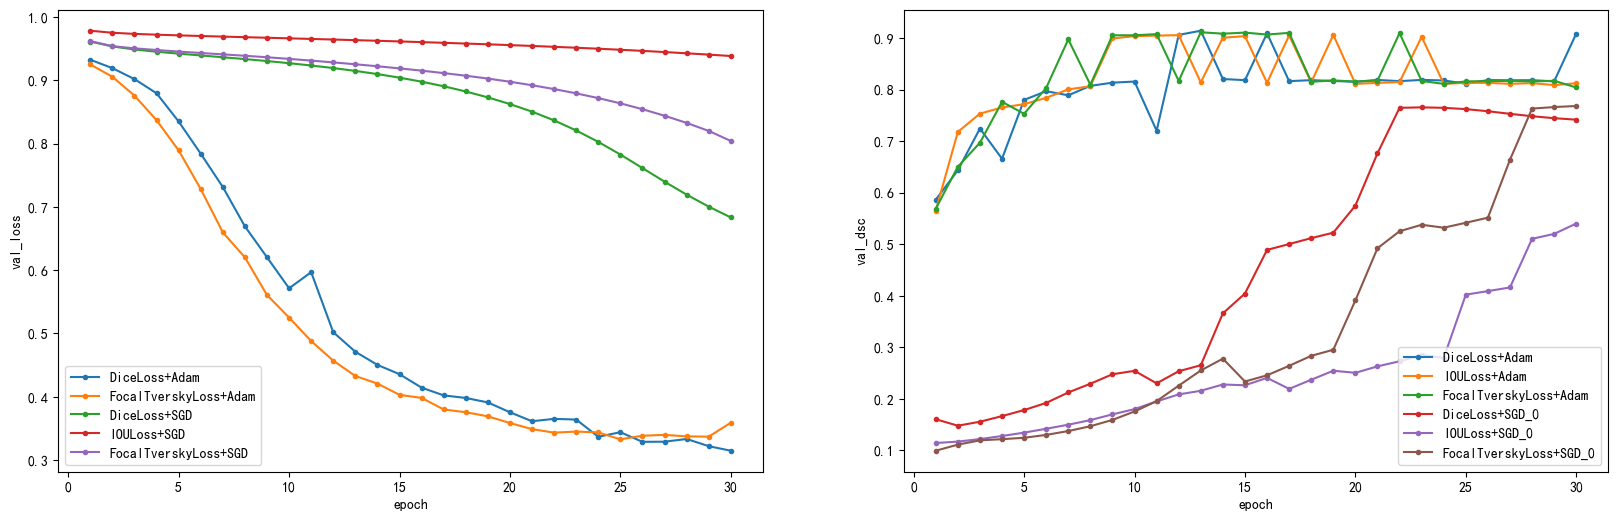

In [44]:
exec_DiceLoss_Adam = exec_result.query("loss_function == 'DiceLoss' & optimizer_function == 'Adam' & weight_decay ==0 & use_lr_scheduler ==False")
exec_IOULoss_Adam = exec_result.query("loss_function == 'IOULoss' & optimizer_function == 'Adam' & weight_decay ==0 & use_lr_scheduler ==False")
exec_FocalTverskyLoss_Adam = exec_result.query("loss_function == 'FocalLoss' & optimizer_function == 'Adam' & weight_decay ==0 & use_lr_scheduler ==False")
exec_DiceLoss_SGD = exec_result.query("loss_function == 'DiceLoss' & optimizer_function == 'SGD' & momentum==0.9 & weight_decay ==0 & use_lr_scheduler ==False")
exec_IOULoss_SGD = exec_result.query("loss_function == 'IOULoss' & optimizer_function == 'SGD'  & momentum==0.9 & weight_decay ==0 & use_lr_scheduler ==False")
exec_FocalTverskyLoss_SGD = exec_result.query("loss_function == 'FocalLoss' & optimizer_function == 'SGD' & momentum==0.9  & weight_decay ==0 & use_lr_scheduler ==False")

plt.figure(figsize=(20,6), dpi=100)
plt.rcParams['font.sans-serif']=['SimHei']
plt.subplot(121)
plt.plot(range(1,len(exec_DiceLoss_Adam)+1),exec_DiceLoss_Adam['val_loss'], marker='.', label ='DiceLoss+Adam')
plt.plot(range(1,len(exec_FocalTverskyLoss)+1),exec_FocalTverskyLoss['val_loss'], marker='.', label ='FocalTverskyLoss+Adam')
plt.plot(range(1,len(exec_DiceLoss_SGD)+1),exec_DiceLoss_SGD['val_loss'], marker='.', label ='DiceLoss+SGD')
plt.plot(range(1,len(exec_IOULoss_SGD)+1),exec_IOULoss_SGD['val_loss'], marker='.', label ='IOULoss+SGD')
plt.plot(range(1,len(exec_FocalTverskyLoss_SGD)+1),exec_FocalTverskyLoss_SGD['val_loss'], marker='.', label ='FocalTverskyLoss+SGD')
plt.xlabel('epoch')
plt.ylabel('val_loss')
plt.legend()
plt.subplot(122)
plt.plot(range(1,len(exec_DiceLoss_Adam)+1),exec_DiceLoss_Adam['val_dsc'], marker='.', label ='DiceLoss+Adam')
plt.plot(range(1,len(exec_IOULoss_Adam)+1),exec_IOULoss_Adam['val_dsc'], marker='.', label ='IOULoss+Adam')
plt.plot(range(1,len(exec_FocalTverskyLoss_Adam)+1),exec_FocalTverskyLoss_Adam['val_dsc'], marker='.', label ='FocalTverskyLoss+Adam')
plt.plot(range(1,len(exec_DiceLoss_SGD)+1),exec_DiceLoss_SGD['val_dsc'], marker='.', label ='DiceLoss+SGD_0')
plt.plot(range(1,len(exec_IOULoss_SGD)+1),exec_IOULoss_SGD['val_dsc'], marker='.', label ='IOULoss+SGD_0')
plt.plot(range(1,len(exec_FocalTverskyLoss_SGD)+1),exec_FocalTverskyLoss_SGD['val_dsc'], marker='.', label ='FocalTverskyLoss+SGD_0')
plt.xlabel('epoch')
plt.ylabel('val_dsc')
plt.legend()
plt.show()

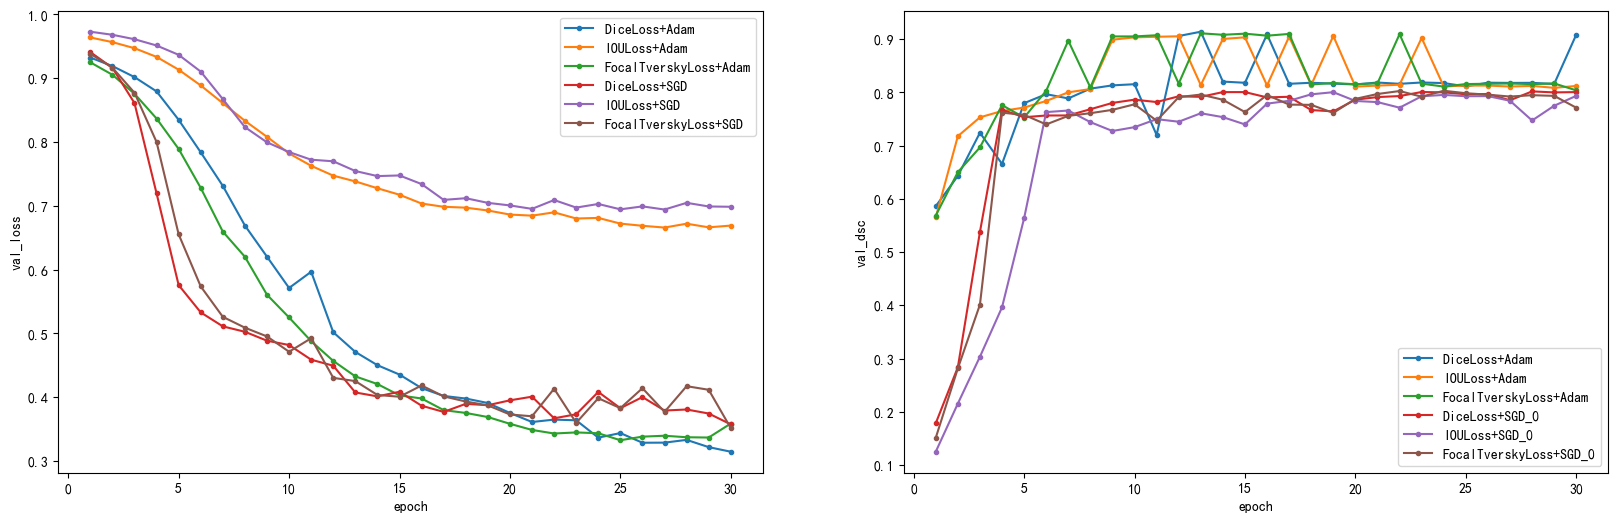

In [46]:
exec_DiceLoss_Adam = exec_result.query("loss_function == 'DiceLoss' & optimizer_function == 'Adam' & weight_decay ==0 & use_lr_scheduler ==False")
exec_IOULoss_Adam = exec_result.query("loss_function == 'IOULoss' & optimizer_function == 'Adam' & weight_decay ==0 & use_lr_scheduler ==False")
exec_FocalTverskyLoss_Adam = exec_result.query("loss_function == 'FocalLoss' & optimizer_function == 'Adam' & weight_decay ==0 & use_lr_scheduler ==False")
exec_DiceLoss_SGD = exec_result.query("loss_function == 'DiceLoss' & optimizer_function == 'SGD' & momentum==0.99 & weight_decay ==0 & use_lr_scheduler ==False")
exec_IOULoss_SGD = exec_result.query("loss_function == 'IOULoss' & optimizer_function == 'SGD'  & momentum==0.99 & weight_decay ==0 & use_lr_scheduler ==False")
exec_FocalTverskyLoss_SGD = exec_result.query("loss_function == 'FocalLoss' & optimizer_function == 'SGD' & momentum==0.99  & weight_decay ==0 & use_lr_scheduler ==False")

plt.figure(figsize=(20,6), dpi=100)
plt.rcParams['font.sans-serif']=['SimHei']
plt.subplot(121)
plt.plot(range(1,len(exec_DiceLoss_Adam)+1),exec_DiceLoss_Adam['val_loss'], marker='.', label ='DiceLoss+Adam')
plt.plot(range(1,len(exec_IOULoss_Adam)+1),exec_IOULoss_Adam['val_loss'], marker='.', label ='IOULoss+Adam')
plt.plot(range(1,len(exec_FocalTverskyLoss)+1),exec_FocalTverskyLoss['val_loss'], marker='.', label ='FocalTverskyLoss+Adam')
plt.plot(range(1,len(exec_DiceLoss_SGD)+1),exec_DiceLoss_SGD['val_loss'], marker='.', label ='DiceLoss+SGD')
plt.plot(range(1,len(exec_IOULoss_SGD)+1),exec_IOULoss_SGD['val_loss'], marker='.', label ='IOULoss+SGD')
plt.plot(range(1,len(exec_FocalTverskyLoss_SGD)+1),exec_FocalTverskyLoss_SGD['val_loss'], marker='.', label ='FocalTverskyLoss+SGD')
plt.xlabel('epoch')
plt.ylabel('val_loss')
plt.legend()
plt.subplot(122)
plt.plot(range(1,len(exec_DiceLoss_Adam)+1),exec_DiceLoss_Adam['val_dsc'], marker='.', label ='DiceLoss+Adam')
plt.plot(range(1,len(exec_IOULoss_Adam)+1),exec_IOULoss_Adam['val_dsc'], marker='.', label ='IOULoss+Adam')
plt.plot(range(1,len(exec_FocalTverskyLoss_Adam)+1),exec_FocalTverskyLoss_Adam['val_dsc'], marker='.', label ='FocalTverskyLoss+Adam')
plt.plot(range(1,len(exec_DiceLoss_SGD)+1),exec_DiceLoss_SGD['val_dsc'], marker='.', label ='DiceLoss+SGD_0')
plt.plot(range(1,len(exec_IOULoss_SGD)+1),exec_IOULoss_SGD['val_dsc'], marker='.', label ='IOULoss+SGD_0')
plt.plot(range(1,len(exec_FocalTverskyLoss_SGD)+1),exec_FocalTverskyLoss_SGD['val_dsc'], marker='.', label ='FocalTverskyLoss+SGD_0')
plt.xlabel('epoch')
plt.ylabel('val_dsc')
plt.legend()
plt.show()

### 3不同的权重衰减系统对结果的影响	

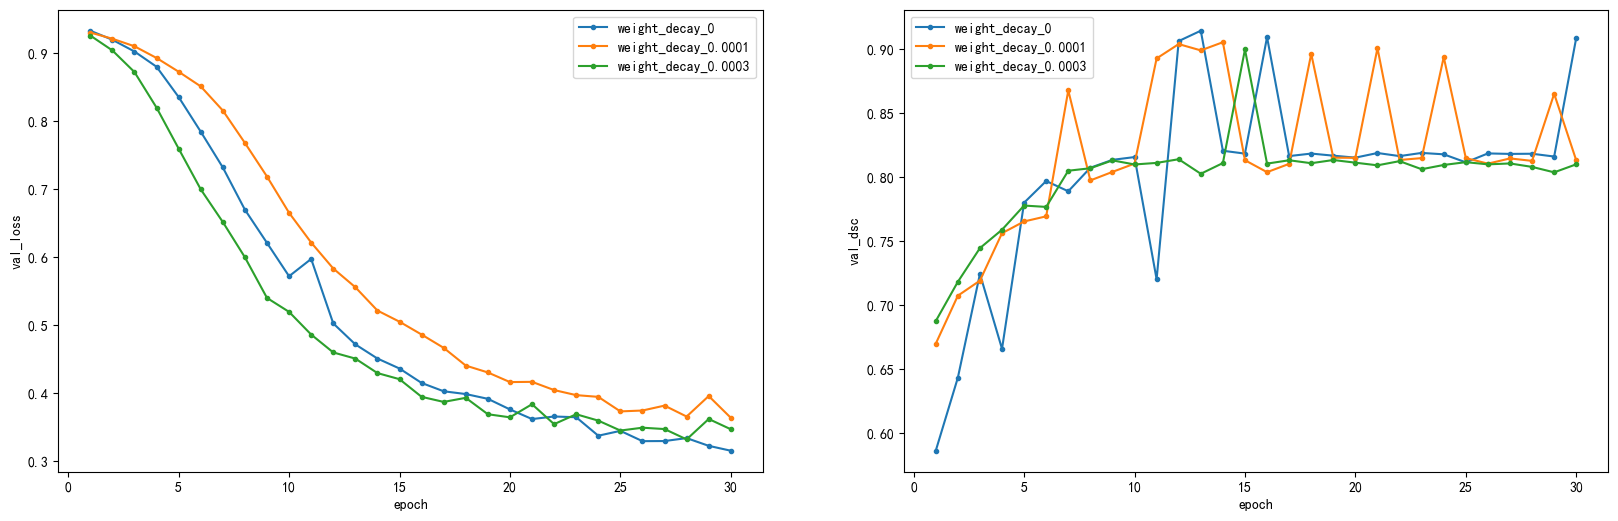

In [47]:
exec_weight_decay_0 = exec_result.query("loss_function == 'DiceLoss' & optimizer_function == 'Adam' & weight_decay ==0 & use_lr_scheduler ==False")
exec_weight_decay_0_0001 = exec_result.query("loss_function == 'DiceLoss' & optimizer_function == 'Adam' & weight_decay ==0.0001 & use_lr_scheduler ==False")
exec_weight_decay_0_0003 = exec_result.query("loss_function == 'DiceLoss' & optimizer_function == 'Adam' & weight_decay ==0.0003 & use_lr_scheduler ==False")

plt.figure(figsize=(20,6), dpi=100)
plt.rcParams['font.sans-serif']=['SimHei']
plt.subplot(121)
plt.plot(range(1,len(exec_weight_decay_0)+1),exec_weight_decay_0['val_loss'], marker='.', label ='weight_decay_0')
plt.plot(range(1,len(exec_weight_decay_0_0001)+1),exec_weight_decay_0_0001['val_loss'], marker='.', label ='weight_decay_0.0001')
plt.plot(range(1,len(exec_weight_decay_0_0003)+1),exec_weight_decay_0_0003['val_loss'], marker='.', label ='weight_decay_0.0003')
plt.xlabel('epoch')
plt.ylabel('val_loss')
plt.legend()
plt.subplot(122)
plt.plot(range(1,len(exec_weight_decay_0)+1),exec_weight_decay_0['val_dsc'], marker='.', label ='weight_decay_0')
plt.plot(range(1,len(exec_weight_decay_0_0001)+1),exec_weight_decay_0_0001['val_dsc'], marker='.', label ='weight_decay_0.0001')
plt.plot(range(1,len(exec_weight_decay_0_0003)+1),exec_weight_decay_0_0003['val_dsc'], marker='.', label ='weight_decay_0.0003')
plt.xlabel('epoch')
plt.ylabel('val_dsc')
plt.legend()
plt.show()


### 4是否使用学习率衰减对结果的影响

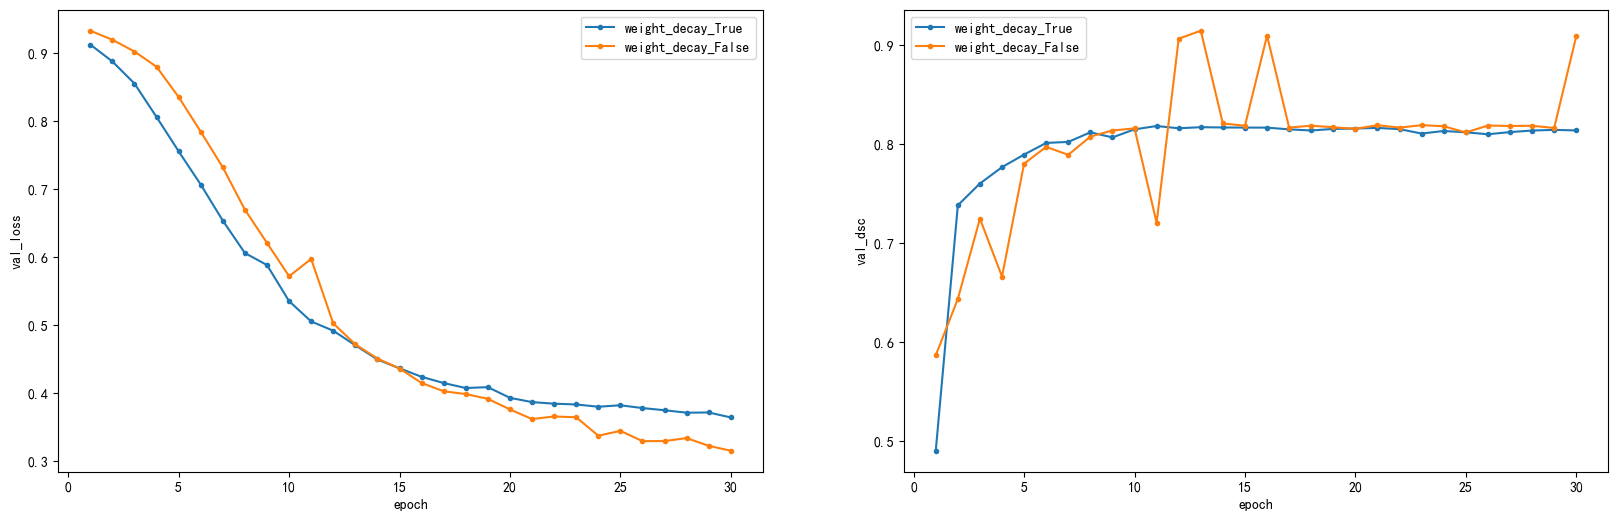

In [48]:
use_lr_scheduler_1 = exec_result.query("loss_function == 'DiceLoss' & optimizer_function == 'Adam' & weight_decay ==0 & use_lr_scheduler ==True")
use_lr_scheduler_0 = exec_result.query("loss_function == 'DiceLoss' & optimizer_function == 'Adam' & weight_decay ==0 & use_lr_scheduler ==False")

plt.figure(figsize=(20,6), dpi=100)
plt.rcParams['font.sans-serif']=['SimHei']
plt.subplot(121)
plt.plot(range(1,len(use_lr_scheduler_1)+1),use_lr_scheduler_1['val_loss'], marker='.', label ='weight_decay_True')
plt.plot(range(1,len(use_lr_scheduler_0)+1),use_lr_scheduler_0['val_loss'], marker='.', label ='weight_decay_False')
plt.xlabel('epoch')
plt.ylabel('val_loss')
plt.legend()
plt.subplot(122)
plt.plot(range(1,len(use_lr_scheduler_1)+1),use_lr_scheduler_1['val_dsc'], marker='.', label ='weight_decay_True')
plt.plot(range(1,len(use_lr_scheduler_0)+1),use_lr_scheduler_0['val_dsc'], marker='.', label ='weight_decay_False')
plt.xlabel('epoch')
plt.ylabel('val_dsc')
plt.legend()
plt.show()